In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# === Step 1: Import Required Libraries ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import pandas as pd
from skimage.morphology import binary_dilation, binary_closing, disk

In [105]:
# === Step 2: Define Paths ===

# Brightfield path (required)
brightfield_path = "/content/drive/MyDrive/OneDrive_1_6-24-2025/Test_2/BRIGHTFIELD_16358_02112020_1358.jpg"

# GFP path (optional)
gfp_path = None  # Or set to your GFP image path

In [106]:
# === Step 3: Load Brightfield Image ===

img_bf = cv2.imread(brightfield_path, cv2.IMREAD_UNCHANGED)
img_bf = cv2.normalize(img_bf, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [107]:
# === Step 4: Detect Organoid from Brightfield as One Object ===

# Threshold using Otsu's method on blurred image
blurred = cv2.GaussianBlur(img_bf, (11, 11), 0)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological processing to merge fragments
clean = morphology.remove_small_objects(thresh.astype(bool), min_size=2000)
clean = binary_dilation(clean, disk(20))
clean = binary_closing(clean, disk(20))

# Treat all connected regions as a single organoid
organoid_mask = measure.label(clean) > 0

In [108]:
# === Step 5: Analyze Brightfield Morphology ===

props = measure.regionprops(organoid_mask.astype(int))

if not props:
    raise ValueError("No organoid detected.")

org = props[0]
y0, x0 = org.centroid
area = org.area
perimeter = org.perimeter
circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

In [109]:
# === Step 6: Process GFP (Optional) ===

gfp_area = 0
gfp_mean_intensity = 0
gfp_total_intensity = 0
gfp_positive_mask = np.zeros_like(organoid_mask, dtype=np.uint8)

if gfp_path is not None:
    img_gfp = cv2.imread(gfp_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    gfp_values = img_gfp[organoid_mask == 1]
    gfp_min, gfp_max = np.percentile(gfp_values, [1, 99])
    gfp_norm = np.clip((img_gfp - gfp_min) / (gfp_max - gfp_min), 0, 1)
    gfp_norm = gfp_norm * organoid_mask

    gfp_thresh_val = 0.85
    gfp_positive_mask = (gfp_norm > gfp_thresh_val).astype(np.uint8)

    gfp_area = np.sum(gfp_positive_mask)
    if gfp_area > 0:
        gfp_mean_intensity = np.mean(gfp_norm[gfp_positive_mask == 1])
        gfp_total_intensity = np.sum(gfp_norm[gfp_positive_mask == 1])

In [110]:
# === Step 7: Save Results ===

results_df = pd.DataFrame([{
    "centroid_x": round(x0, 2),
    "centroid_y": round(y0, 2),
    "area": round(area, 2),
    "perimeter": round(perimeter, 2),
    "circularity": round(circularity, 4),
    "gfp_positive_area": int(gfp_area),
    "gfp_mean_intensity": round(gfp_mean_intensity, 4),
    "gfp_total_intensity": round(gfp_total_intensity, 4)
}])

print(results_df)

results_df.to_csv("/content/drive/MyDrive/Imaging/organoid_gfp_analysis.csv", index=False)

   centroid_x  centroid_y       area  perimeter  circularity  \
0      1336.2       961.1  1633085.0   13004.67       0.1213   

   gfp_positive_area  gfp_mean_intensity  gfp_total_intensity  
0                  0                   0                    0  


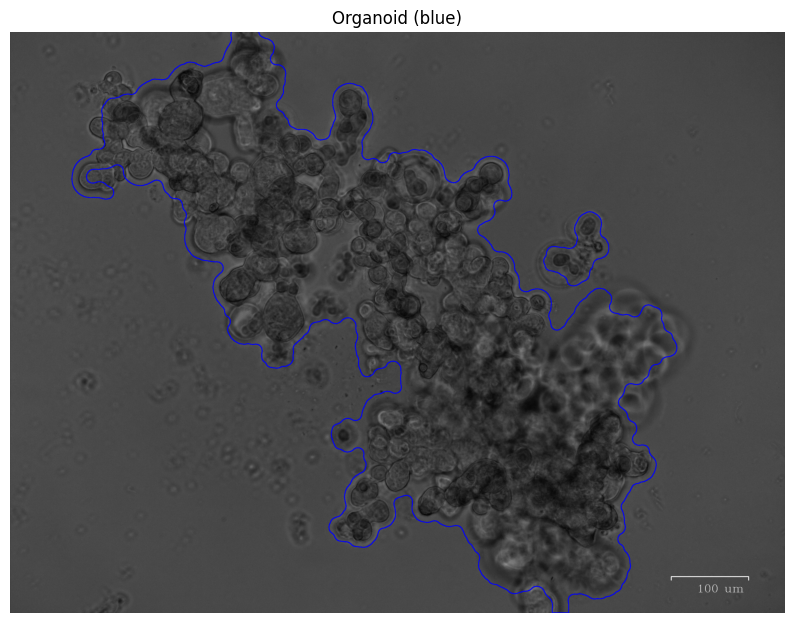

In [111]:
# === Step 8: Create Overlay Image ===

overlay = cv2.cvtColor(img_bf, cv2.COLOR_GRAY2BGR)

if gfp_path is not None:
    overlay[gfp_positive_mask.astype(bool)] = [255, 0, 0]  # Red

# Draw contours in blue
contours, _ = cv2.findContours(organoid_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0, 0, 255), 2)  # Blue outline

# Display
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title("Organoid (blue)" + (" + GFP+ (red)" if gfp_path else ""))
plt.axis("off")
plt.show()